# Preliminary analysis
This notebook contains the calculations for the basic statistics about the unprocessed cleaned datasets, used in the "Dataset description" section in the thesis.

## Euroleaks

In [1]:
import numpy as np
import pandas as pd
import re
import json

import matplotlib.pyplot as plt

In [34]:
df = pd.read_csv('../data/euroleaks/cleaned.csv')
df.head()

,speaker,speech,timestamp,date
0,jeroen dijsselbloem,… of your responses or questions. and can i fi...,1900-01-01 00:00:00,2015-02-24 00:00:00
1,speaker 2,"uh, yes, uh, thank you, jeroen. well, uh, comm...",1900-01-01 00:00:10,2015-02-24 00:00:00
2,michael noonan,michael noonan.,1900-01-01 00:01:27,2015-02-24 00:00:00
3,speaker 2,"uh, it is therefore regrettable that, uh-",1900-01-01 00:01:29,2015-02-24 00:00:00
4,speaker 2,"… that the letter by the minister does not, uh...",1900-01-01 00:01:37,2015-02-24 00:00:00


In [36]:
df[df.speaker=='speaker 3'].date.unique()

array(['2015-06-18 00:00:00', '2015-06-25 00:00:00'], dtype=object)

## word count by speaker

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer() # does tokenization under the hood
X = vectorizer.fit_transform(df.speech)

df['wordcount'] = X.toarray().sum(axis=1)

wc_by_speaker = df.groupby('speaker')['wordcount'].sum()

In [5]:
wc_by_speaker.describe(percentiles=[.25,.5,.75,.9,.95,.99])

count       59.000000
mean      1478.627119
std       3734.749763
min          5.000000
25%        149.500000
50%        388.000000
75%       1310.500000
90%       3054.000000
95%       3729.400000
99%      19392.340000
max      23990.000000
Name: wordcount, dtype: float64

In [6]:
print(f'There are {wc_by_speaker.sum()} total words in Euroleaks after preparing the text.')

unkown_names = [
    'irina',
    'nabil',
    'tropa',
    'martin',
    'kian',
    'male'
]

is_named = wc_by_speaker.index.to_series().apply(lambda s: 'speaker' not in s and s not in unkown_names).to_numpy()
print(f'Of those, {wc_by_speaker[np.invert(is_named)].sum()} ({np.around(wc_by_speaker[np.invert(is_named)].sum()/wc_by_speaker.sum()*100,2)} %) belong to unidentified speakers.')

There are 87239 total words in Euroleaks after preparing the text.
Of those, 5636 (6.46 %) belong to unidentified speakers.


### all speakers

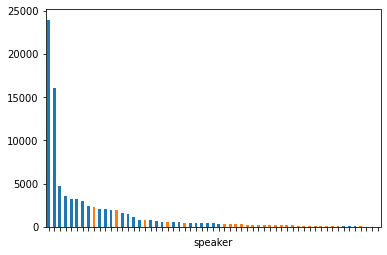

In [7]:
is_named = wc_by_speaker.index.to_series().apply(lambda s: 'speaker' not in s and s not in unkown_names).to_numpy()

cmap = np.array([u'#ff7f0e', u'#1f77b4'])

color = cmap[is_named.astype(int)]

ax = wc_by_speaker.sort_values(ascending=False).plot.bar(color=color)
labels = ax.set_xticklabels([])

### identified speakers

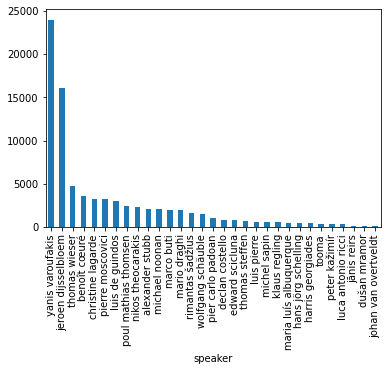

In [8]:
ax = wc_by_speaker[is_named].sort_values(ascending=False).plot.bar()

### unidentified speakers

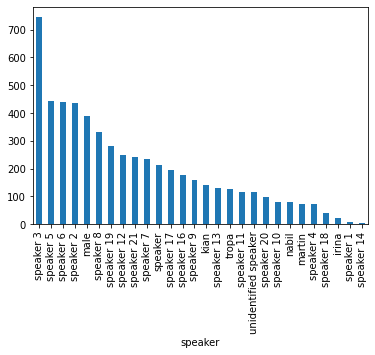

In [9]:
ax = wc_by_speaker[np.invert(is_named)].sort_values(ascending=False).plot.bar()

### proportion of unnamed speakers

In [10]:
x = wc_by_speaker[np.invert(is_named)].sum() / wc_by_speaker.sum()

print(f'{np.round(x*100,4)} % of words belong to unnamed speakers.')

6.4604 % of words belong to unnamed speakers.


### joint plot for the appendix (identified + unidentified speakers)

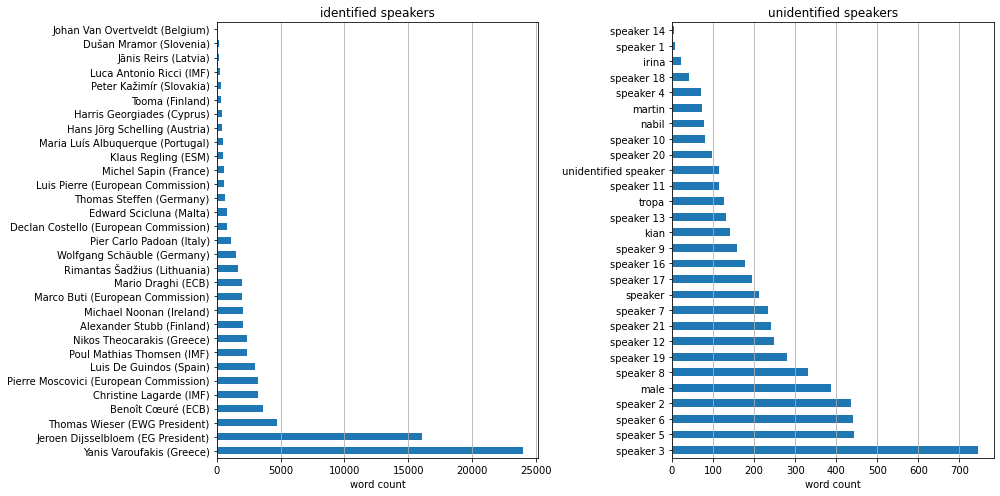

In [11]:
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)

fig, axes = plt.subplots(1,2, figsize=(14,7))

wc_by_speaker[is_named].sort_values(ascending=False).plot.barh(ax=axes[0])
axes[0].set_xlabel('word count')
axes[0].set_ylabel('')
axes[0].grid(axis='x')
axes[0].set_title('identified speakers')

labels = pd.Series([t.get_text() for t in axes[0].get_yticklabels()]).apply(lambda s: 
        f'{s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})')

axes[0].set_yticklabels(labels)


wc_by_speaker[np.invert(is_named)].sort_values(ascending=False).plot.barh(ax=axes[1])
#axes[1].set_xlabel('unidentified speaker')
axes[1].set_xlabel('word count')
axes[1].set_ylabel('')
axes[1].grid(axis='x')
axes[1].set_title('unidentified speakers')

fig.tight_layout()

In [12]:
df.drop(columns=['timestamp'], inplace=True)
df.head()

,speaker,speech,date,wordcount
0,jeroen dijsselbloem,… of your responses or questions. and can i fi...,2015-02-24 00:00:00,19
1,speaker 2,"uh, yes, uh, thank you, jeroen. well, uh, comm...",2015-02-24 00:00:00,169
2,michael noonan,michael noonan.,2015-02-24 00:00:00,2
3,speaker 2,"uh, it is therefore regrettable that, uh-",2015-02-24 00:00:00,7
4,speaker 2,"… that the letter by the minister does not, uh...",2015-02-24 00:00:00,154


In [13]:
df['identified'] = df.speaker.apply(lambda s: 'speaker' not in s and s not in unkown_names).to_numpy()

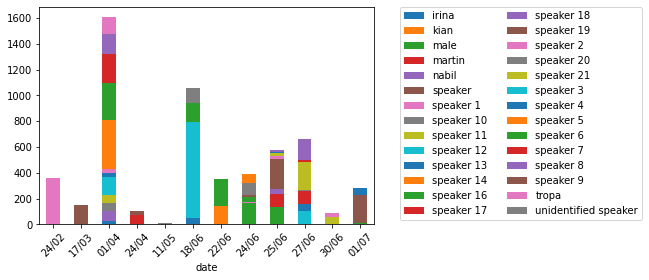

In [14]:
ax = df[df.identified == False].groupby(['date', 'speaker']).sum().wordcount.unstack().plot.bar(stacked=True)

ax.legend(loc='upper right', bbox_to_anchor= (1.8, 1), ncol=2,
            borderaxespad=0, frameon=True)

dates = pd.Series([t.get_text() for t in ax.get_xticklabels()]).apply(lambda s: pd.to_datetime(s).strftime('%d/%m'))
_ = ax.set_xticklabels(dates, rotation=45)

plt.savefig('../figures/unidentified-sepaker-date.png')

In [15]:
np.unique(df.date).size

12

## word count by entity

In [16]:
with open('../data/euroleaks/name_to_entity.json', 'r') as f:
    speaker_to_entity = json.load(f)

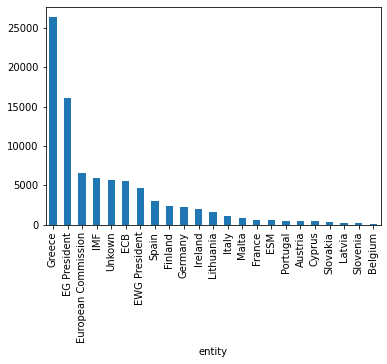

In [17]:
# add column for entity, label unassigned as unknown
df['entity'] = df.speaker.apply(lambda s: speaker_to_entity[s] if s in speaker_to_entity.keys() else 'Unkown')

wc_by_entity = df.groupby('entity')['wordcount'].sum()

_ = wc_by_entity.sort_values(ascending=False).plot.bar()

### group institutions together

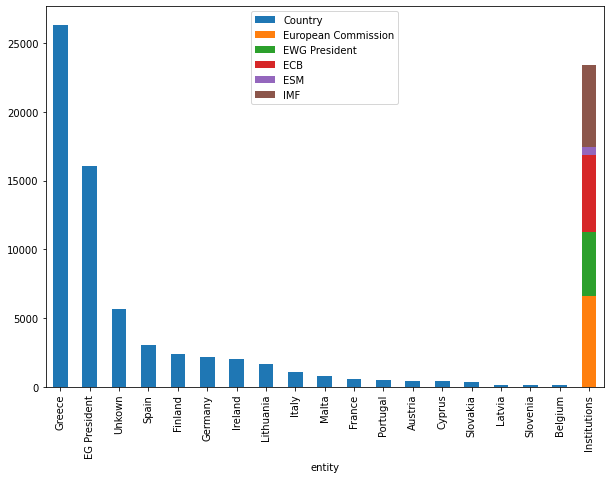

In [18]:
wcent = pd.DataFrame({
    'total': wc_by_entity,
    'Country': wc_by_entity,
    'European Commission': np.zeros(wc_by_entity.size, dtype=int),
    'EWG President': np.zeros(wc_by_entity.size, dtype=int),
    'ECB': np.zeros(wc_by_entity.size, dtype=int),
    'ESM': np.zeros(wc_by_entity.size, dtype=int),
    'IMF': np.zeros(wc_by_entity.size, dtype=int)
})

wcent.loc['Institutions'] = np.array([
    0,
    0,
    wc_by_entity.loc['European Commission'],
    wc_by_entity.loc['EWG President'],
    wc_by_entity.loc['ECB'],
    wc_by_entity.loc['ESM'],
    wc_by_entity.loc['IMF']
])

wcent['Country'][(wcent.index.to_numpy() == 'EWG President') | (wcent.index.to_numpy() == 'ECB') | (wcent.index.to_numpy() == 'ESM') |(wcent.index.to_numpy() == 'IMF') | (wcent.index.to_numpy() == 'European Commission')] = 0

_ = wcent.sort_values(by='total', ascending=False).drop(columns=['total'], index=['European Commission', 'EWG President', 'ECB', 'ESM', 'IMF']).plot.bar(stacked=True, figsize=(10,7))

Same as above but values as fractions.

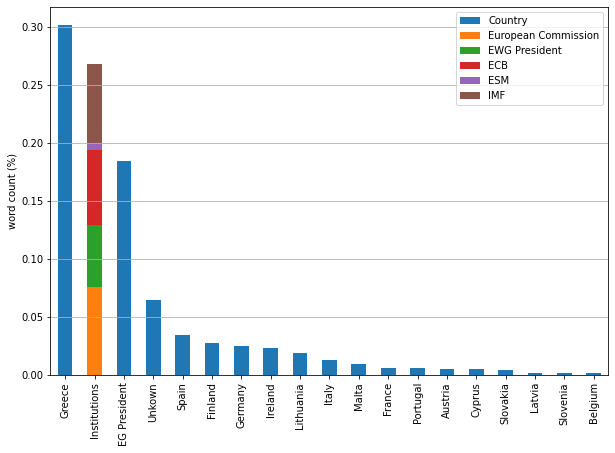

In [19]:
#plt.rcParams.update({'font.size': 12})

# sort descendingly
df_to_plot = wcent.sort_values(by='total', ascending=False).drop(columns=['total'], index=['European Commission', 'EWG President', 'ECB', 'ESM', 'IMF'])

# make fractions
df_to_plot /= np.repeat(df_to_plot.sum().sum(), df_to_plot.shape[0]*df_to_plot.shape[1]).reshape(df_to_plot.shape)

# reorder and plot bars
ax = df_to_plot.iloc[[0,-1,]+list(range(1,18))].plot.bar(stacked=True, figsize=(10,7))

ax.set_ylabel('word count (%)')
ax.grid(axis='y')
#ax.set_title('Wordcount by entity')
xticks = ax.set_xticklabels(df_to_plot.index.to_series().iloc[[0,-1,]+list(range(1,18))], rotation=90)
#xticks[2] = 'EG President'
#_ = ax.set_xticklabels(xticks)
ax.set_xlabel('')

plt.subplots_adjust(bottom=0.15) # so that xticklabels are not cut off
plt.savefig('../figures/wordcount_by_entity.png')

## heatmap for how much each speaker speaks over time

In [20]:
# speakers of bottom 25% by least-said
insignificant_speakers = wc_by_speaker.index[wc_by_speaker < 160].to_numpy()

In [21]:
np.percentile(wc_by_speaker, 25)

149.5

In [22]:
insignificant_speakers

array(['dušan mramor', 'irina', 'johan van overtveldt', 'kian', 'martin',
       'nabil', 'speaker 1', 'speaker 10', 'speaker 11', 'speaker 13',
       'speaker 14', 'speaker 18', 'speaker 20', 'speaker 4', 'speaker 9',
       'tropa', 'unidentified speaker'], dtype=object)

In [23]:
X = df[df.speaker.apply(lambda s: 
                        s not in insignificant_speakers and 
                        'speaker' not in s and
                        s != 'male'
                       )]\
    .groupby(['date','speaker'])['wordcount']\
    .sum().unstack().fillna(0).T

In [24]:
X.columns = X.columns.to_series().apply(lambda s: pd.to_datetime(s).strftime('%d/%m'))

In [25]:
# don't do this because then you could barely see the rest in the plot
#X['total'] = X.sum(axis=1)

In [26]:
X.head()

date,24/02,17/03,01/04,24/04,11/05,18/06,22/06,24/06,25/06,27/06,30/06,01/07
speaker,,,,,,,,,,,,
alexander stubb,0.0,0.0,0.0,0.0,0.0,467.0,0.0,0.0,947.0,506.0,119.0,0.0
benoît cœuré,0.0,640.0,1061.0,0.0,1108.0,417.0,29.0,0.0,0.0,0.0,0.0,366.0
christine lagarde,424.0,0.0,0.0,0.0,0.0,0.0,993.0,528.0,775.0,539.0,0.0,0.0
declan costello,0.0,817.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
edward scicluna,0.0,0.0,0.0,72.0,0.0,0.0,0.0,361.0,213.0,149.0,0.0,0.0


In [27]:
#X = X.drop(index=['yanis varoufakis', 'jeroen dijsselbloem', 'thomas wieser'])

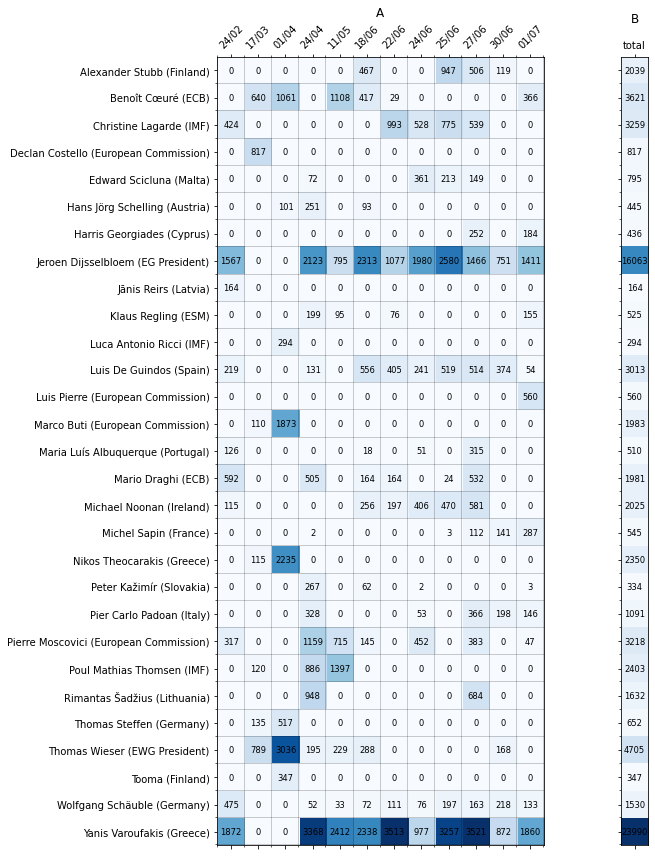

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12,12), sharey=True)

cmap = 'Blues'

##############
### axis 0 ###
##############

# plot
axes[0].matshow(X, cmap=cmap)

# xticks
dates = X.columns.to_numpy()
_ = axes[0].set_xticks(range(len(dates)))
_ = axes[0].set_xticklabels(dates, rotation=45)
# yticks
_ = axes[0].set_yticks(range(X.index.size))
_ = axes[0].set_yticklabels(X.index.to_series().apply(lambda s: 
        f'{s.title()} ({speaker_to_entity[s] if s in speaker_to_entity.keys() else "Unkown"})'))

# grids
axes[0].set_xticks(np.arange(-.53, len(dates), 1), minor=True)
axes[0].set_yticks(np.arange(X.index.size))
axes[0].set_yticks(np.arange(-.53, X.index.size, 1), minor=True)
axes[0].grid(which='minor', color='black', linestyle='-', linewidth=.5, alpha=.4)

# values
for (i,j),z in np.ndenumerate(X.to_numpy()):
    axes[0].text(j, i, int(z), ha='center', va='center', fontsize='small')
    
axes[0].set_title('A')

##############
### axis 1 ###
##############

# plot
axes[1].matshow(X.sum(axis=1).to_numpy().reshape(-1,1), cmap=cmap)

# xticks
_ = axes[1].set_xticks([0])
_ = axes[1].set_xticklabels(['\ntotal'], rotation='horizontal')
# yticks
_ = axes[1].set_yticks(range(X.index.size))


# values
for i,z in enumerate(X.sum(axis=1).to_numpy()):
    axes[1].text(0, i, int(z), ha='center', va='center', fontsize='small')
    
axes[1].set_title('B')

fig.tight_layout()

#fig.subplots_adjust(wspace=0.001)
    
fig.savefig('../figures/wordcount_heatmap.png')

## Communiques

In [29]:
df = pd.read_csv('../data/communiques/cleaned.csv')
df.head()

,date,title,story
0,2015-02-12,remarks by jeroen dijsselbloem at the press co...,"good evening. today, as you well know, we had ..."
1,2015-02-16,remarks by jeroen dijsselbloem at the press co...,good evening everyone and thanks for joining t...
2,2015-02-20,eurogroup statement on greece,the eurogroup reiterates its appreciation for ...
3,2015-02-20,remarks by jeroen dijsselbloem at the press co...,good evening and welcome to this press confere...
4,2015-02-24,eurogroup statement on greece,the eurogroup today discussed the first list o...


In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer() # does tokenization under the hood
X = vectorizer.fit_transform(df.story)

df['wordcount'] = X.toarray().sum(axis=1)

In [31]:
df

,date,title,story,wordcount
0,2015-02-12,remarks by jeroen dijsselbloem at the press co...,"good evening. today, as you well know, we had ...",202
1,2015-02-16,remarks by jeroen dijsselbloem at the press co...,good evening everyone and thanks for joining t...,1301
2,2015-02-20,eurogroup statement on greece,the eurogroup reiterates its appreciation for ...,683
3,2015-02-20,remarks by jeroen dijsselbloem at the press co...,good evening and welcome to this press confere...,1039
4,2015-02-24,eurogroup statement on greece,the eurogroup today discussed the first list o...,140
5,2015-04-24,remarks by jeroen dijsselbloem at the press co...,good afternoon and welcome to this press confe...,911
6,2015-05-11,eurogroup statement on greece,the eurogroup today took stock of the state of...,150
7,2015-05-11,remarks by jeroen dijsselbloem at the press co...,good evening and welcome to this press confere...,957
8,2015-06-18,press remarks by eurogroup president following...,good evening. we can start this press conferen...,1001
9,2015-06-22,press remarks by eurogroup president jeroen di...,good afternoon everyone. this will be a very s...,233


In [32]:
df.wordcount.describe()

count      18.00000
mean      473.00000
std       402.57524
min        48.00000
25%       163.00000
50%       267.50000
75%       854.00000
max      1301.00000
Name: wordcount, dtype: float64

In [33]:
print(f'There are {df.wordcount.sum()} total words in Coomuniques after preparing the text.')

There are 8514 total words in Coomuniques after preparing the text.
